In [1]:
#Objective: predicting the trip duration accurately

Extract data we've been given and divide into reasonable chunks

In [2]:
import pandas as pd


file_path = "training_dataset/training_dataset.csv"

chunk_size = 50_000  

chunks = []


for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunks.append(chunk)

data_frame = pd.concat(chunks, ignore_index=True)

sample_size = 100000  
sample_df = data_frame.sample(n=sample_size, random_state=42)  # Load 100000 random rows



Process the data. Remove whatever that's uncessary and check for missing values. Either remove the missing or replace them. 

But first, check what we're missing and working with.

In [3]:
missing_values = sample_df.isnull().sum()
print("Number of missing values are: ", missing_values) 

# Check for missing values
# missing_values = data_frame.isnull().sum()
# print("Number of missing values are: ", missing_values) 

print("-------------------------------------------------")

# Show summary statistics
print(sample_df.info())
print(sample_df.describe())

Number of missing values are:  ID                          0
vendorid                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          9657
trip_distance               0
ratecodeid               9657
store_and_fwd_flag       9657
pulocationid                0
dolocationid                0
payment_type                0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     9657
airport_fee              9657
duration                    0
dtype: int64
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 12321871 to 14069328
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     100000 non-null  object 
 1

We're missing a lot of data from these columns: 

1. passenger_count          3155336

2. ratecodeid               3155336

3. store_and_fwd_flag       3155336

4. congestion_surcharge     3155336

5. airport_fee              3155336


The first four columns are useless for the objective at hand. We'll drop them. 

Whilst we're at it we will remove all other columns that are not useful.

In [4]:
# YOUR CODE HERE
sample_df.drop(columns=["vendorid", "passenger_count", "vendorid", "ratecodeid", "pulocationid", "dolocationid", "payment_type", 
                         "extra","mta_tax","tip_amount","tolls_amount","improvement_surcharge", "congestion_surcharge", "airport_fee", "store_and_fwd_flag"], inplace=True)
sample_df.fillna(0, inplace=True)


Missing values have been addressed as well as useless columns. Now, we'll process the data that is relevant. But first we need to look at what we're working with.

In [5]:
print(sample_df.info())
print(sample_df.describe())
print(sample_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 12321871 to 14069328
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     100000 non-null  object 
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   trip_distance          100000 non-null  float64
 4   fare_amount            100000 non-null  float64
 5   total_amount           100000 non-null  float64
 6   duration               100000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 6.1+ MB
None
       trip_distance    fare_amount   total_amount      duration
count  100000.000000  100000.000000  100000.000000  100000.00000
mean        5.853735      19.167719      27.751261    1041.94614
std       390.969718      18.699488      23.501012    2097.71420
min         0.000000    -700.000000    -702.750000       0.00000
25%         1.020000       

We seem to have a some differences in what sort of data we're working with. Some Datetimes that have useful information; we need to extract that data and convert into numerical values.

In [6]:
sample_df['tpep_pickup_datetime'] = pd.to_datetime(sample_df['tpep_pickup_datetime'])
sample_df['tpep_dropoff_datetime'] = pd.to_datetime(sample_df['tpep_dropoff_datetime'])

# Extract features
sample_df['pickup_hour'] = sample_df['tpep_pickup_datetime'].dt.hour
sample_df['pickup_day'] = sample_df['tpep_pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6

# Drop original datetime columns
# data_frame.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)


After a quick look-through of our data, anomalies such as negative fares, total amounts etc were noted. We'll filter them out right away.

In [7]:
sample_df = sample_df[
    (sample_df['fare_amount'] > 0) & 
    (sample_df['total_amount'] > 0) & 
    (sample_df['duration'] > 0)
]


DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


In [8]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
features = ['trip_distance', 'fare_amount', 'pickup_hour', 'pickup_day', 'duration']
scaled_data = scaler.fit_transform(sample_df[features])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(scaled_data)

# Add clusters to the DataFrame
sample_df['Cluster'] = clusters

# Check the number of clusters (noise is labeled as -1)
print("Cluster distribution:\n", sample_df['Cluster'].value_counts())

Cluster distribution:
 Cluster
 3     15138
 2     14908
 5     14682
 0     14670
 1     13870
 4     12541
 6     11757
-1       455
 10       43
 11       14
 12       14
 16       13
 13        9
 9         7
 17        7
 15        6
 7         6
 8         4
 22        4
 14        4
 21        4
 19        4
 28        4
 18        4
 27        4
 24        4
 25        4
 20        4
 23        4
 26        3
Name: count, dtype: int64


Visualizing Clusters


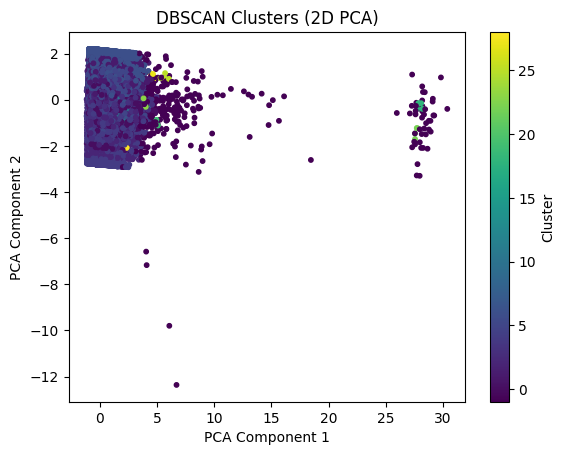

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce data to 2D using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plot clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clusters (2D PCA)')
plt.show()

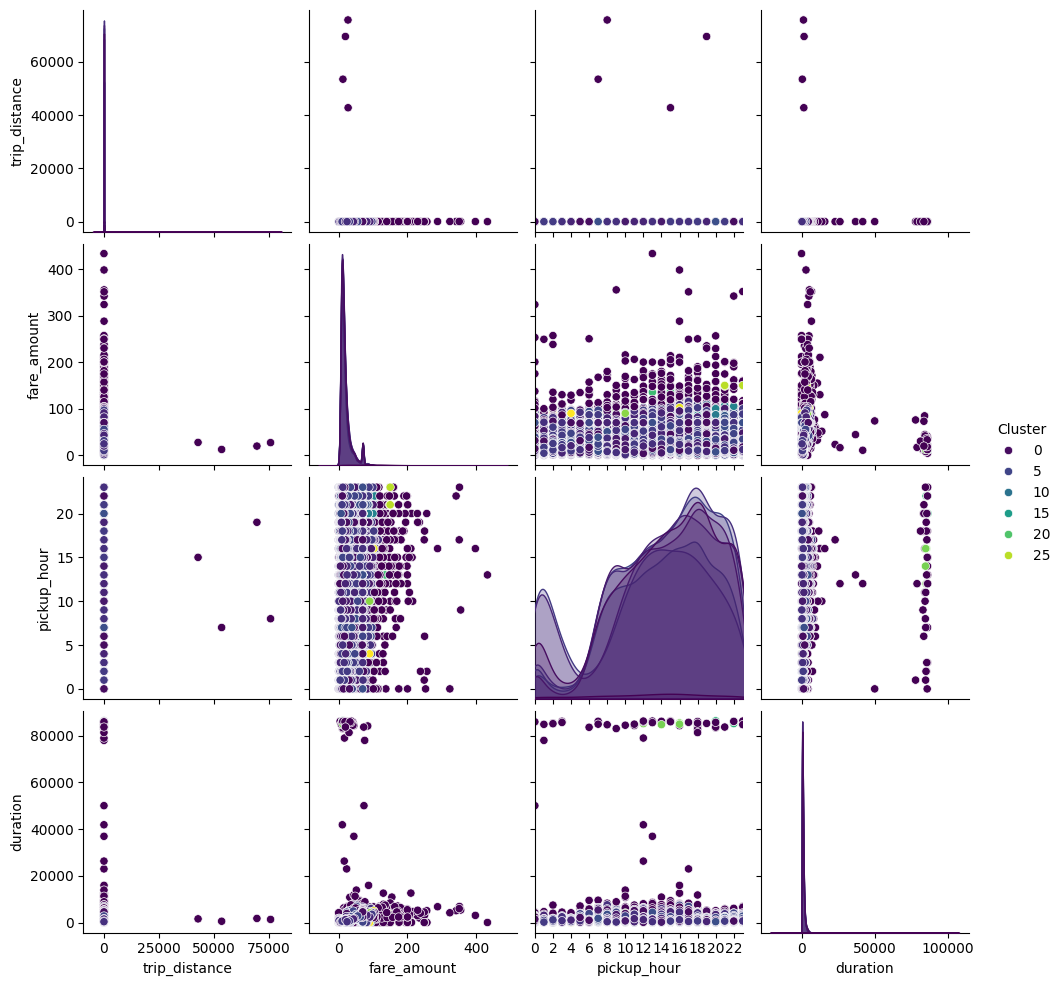

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few key features for visualization
features = ['trip_distance', 'fare_amount', 'pickup_hour', 'duration']

# Create the pair plot
pair_plot = sns.pairplot(sample_df, vars=features, hue='Cluster', palette='viridis')

# Adjust the x-axis limits for pickup_hour
for ax in pair_plot.axes.flatten():
    if ax.get_xlabel() == 'pickup_hour':
        ax.set_xlim(0, 23)  # Set x-axis limits to 0–23
        ax.set_xticks(range(0, 24, 2))  # Show ticks every 2 hours

plt.show()